<a href="https://colab.research.google.com/github/mccoymb/AAE-590-DSMM/blob/main/590DSMM_HW6_4_small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from scipy.fftpack import fft2, ifft2, fftshift
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

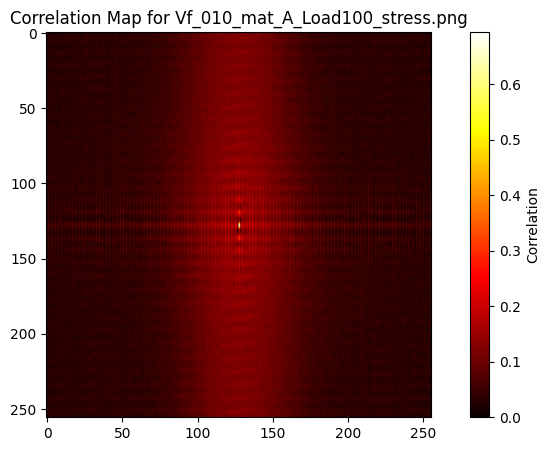

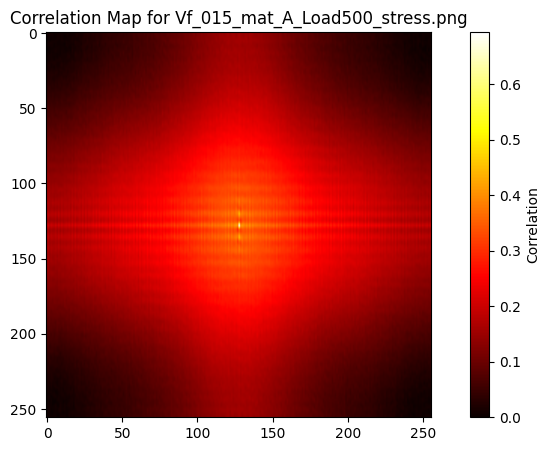

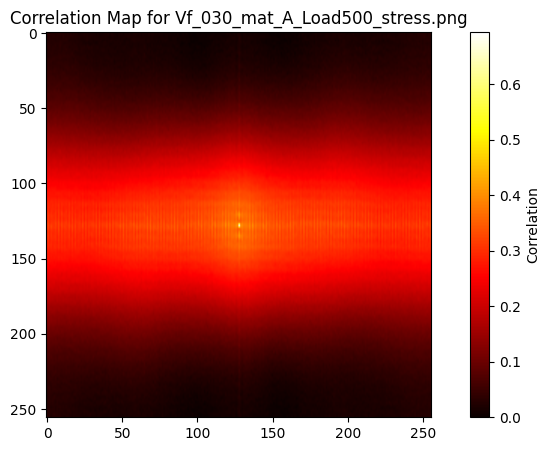

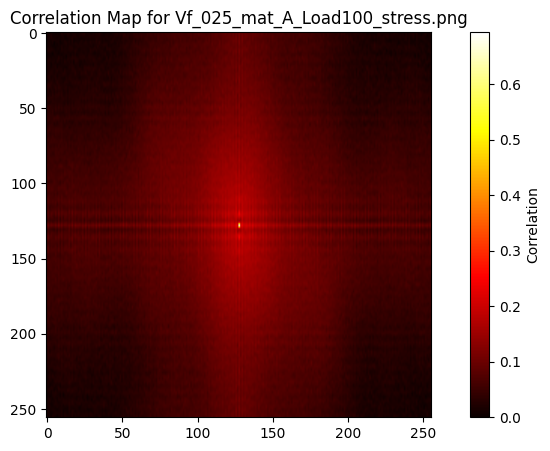

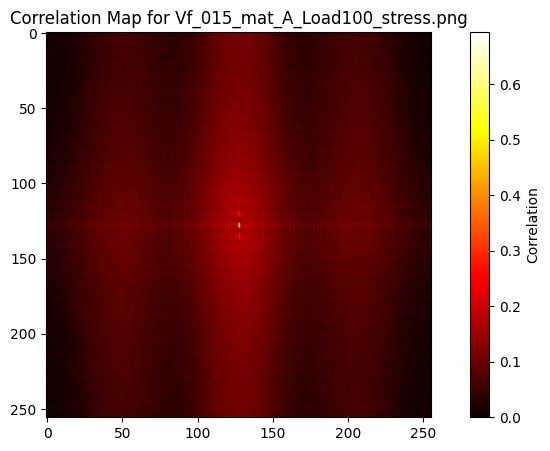

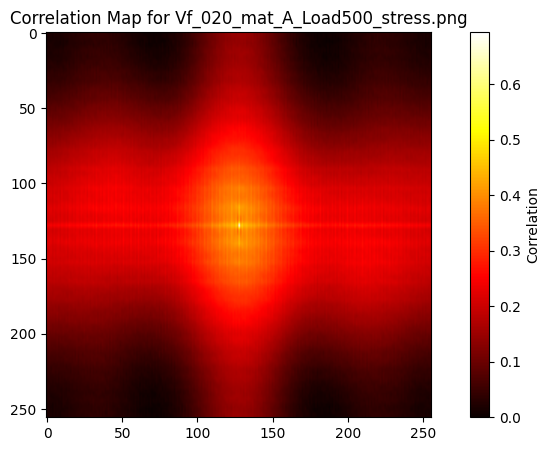

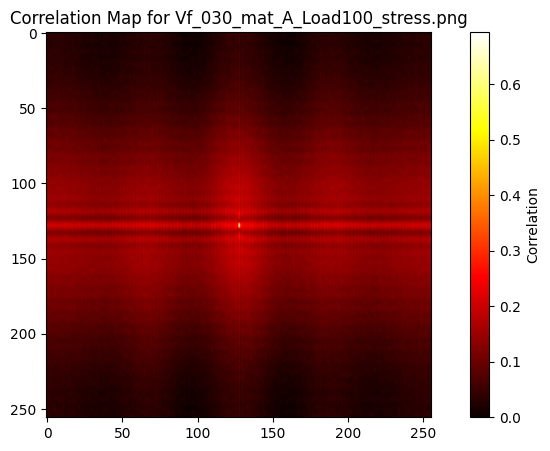

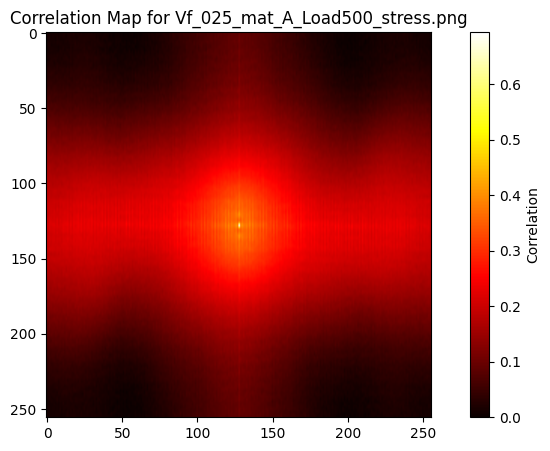

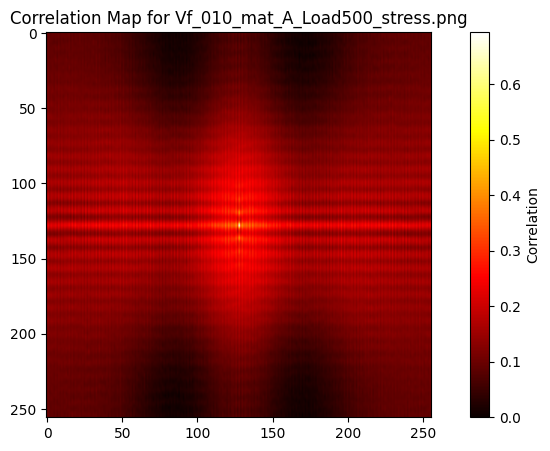

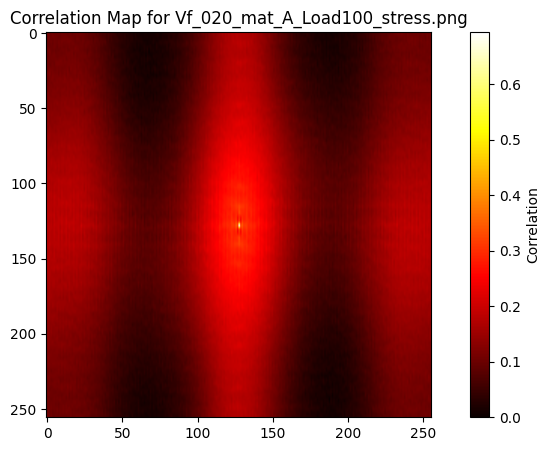

In [6]:
#Functions
def load_image(filepath, target_size=(256, 256)):
    """Load an image, convert to grayscale, and resize to a fixed size."""
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)  # Resize for consistency
    img = img.astype(np.float32) / 255.0  # Normalize intensity
    return img

def two_point_correlation(image):
  """Computes 2 point correlation using FFT"""
  f = fft2(image)
  f_conj = np.conj(f)
  correlation = ifft2(f*f_conj).real
  correlation = fftshift(correlation)
  correlation -=np.min(correlation)
  if np.max(correlation) != 0:
    correlation /= np.max(correlation)
  return correlation


#Start code
image_files = glob.glob("*.png")
correlation_maps = []

for img_file in image_files:
  img = load_image(img_file, target_size=(256, 256))
  correlation = two_point_correlation(img)
  correlation_maps.append(correlation.flatten())
  log_correlation = np.log1p(correlation)
  #Plots
  plt.figure(figsize=(10, 5))
  plt.imshow(log_correlation, cmap="hot", interpolation="bilinear")
  plt.title(f"Correlation Map for {img_file}")
  plt.colorbar(label = "Correlation")
  plt.show()


In [11]:
def radial_average(correlation):
    """Compute radial average of a 2D correlation map."""
    y, x = np.indices(correlation.shape)
    center = np.array(correlation.shape) // 2
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
    r = r.astype(np.int32)

    tpc_profile = np.zeros(r.max() + 1)
    counts = np.zeros(r.max() + 1)

    for i in range(correlation.shape[0]):
        for j in range(correlation.shape[1]):
            ri = r[i, j]
            tpc_profile[ri] += correlation[i, j]
            counts[ri] += 1

    return tpc_profile / counts

#Formatting for PCA Grouping
def extract_load(filename):
    """Extract load 100N or 500N from the filename (assumed format)."""
    import re
    match = re.search(r'Load(\d+)', filename)
    return int(match.group(1)) if match else 0

    # Load images dynamically and sort them by load (VF_0XX)
image_files = sorted(glob.glob("*.png"), key=extract_load)
correlation_profiles = []
loads = []

for img_file in image_files:
    img = load_image(img_file, target_size=(256, 256))
    correlation = two_point_correlation(img)
    correlation_profile = radial_average(correlation)

    correlation_profiles.append(correlation_profile)

    # Extract load value from filename
    vf_value = extract_load(img_file)
    loads.append(vf_value)

# Convert to NumPy array
correlation_profiles = np.array(correlation_profiles)
loads = np.array(loads)



Explained Variance:
PC1: 92.43%
PC2: 6.12%
PC3: 1.07%


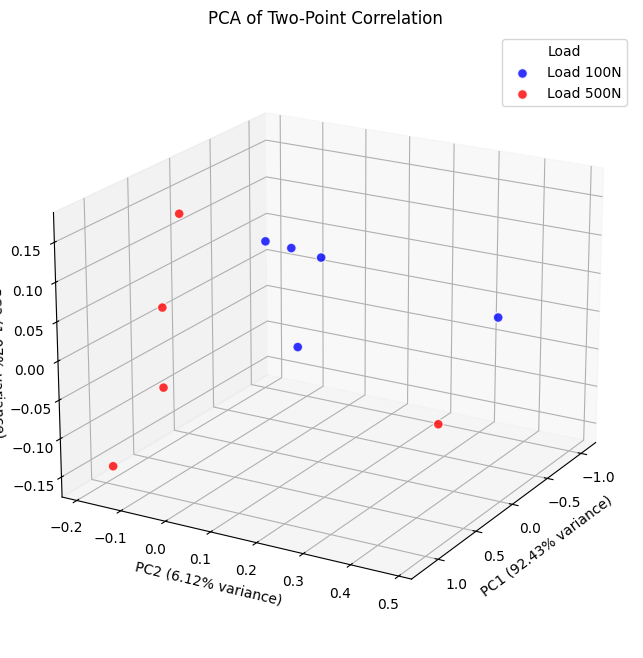

In [12]:
# Perform PCA on correlation profiles
pca = PCA(n_components=3)
pca_results = pca.fit_transform(correlation_profiles)
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance:")
for i, var in enumerate(explained_variance, start=1):
    print(f"PC{i}: {var*100:.2f}%")
colors = {100: 'blue', 500: 'red'}
labels = {100: "Load 100N", 500: "Load 500N"}

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter points separately for each load value to create a legend
for load_value in np.unique(loads):
    mask = (loads == load_value)
    ax.scatter(pca_results[mask, 0], pca_results[mask, 1], pca_results[mask, 2],
               c=colors[load_value], label=labels[load_value], edgecolor='w', s=50, alpha=0.8)

ax.set_xlabel(f"PC1 ({explained_variance[0]*100:.2f}% variance)")
ax.set_ylabel(f"PC2 ({explained_variance[1]*100:.2f}% variance)")
ax.set_zlabel(f"PC3 ({explained_variance[2]*100:.2f}% variance)")
ax.set_title("PCA of Two-Point Correlation")
ax.legend(loc="best", title="Load")
ax.view_init(elev=20, azim=30)
ax.dist = 12
plt.show()


Explained Variance:
PC1: 92.43%
PC2: 6.12%


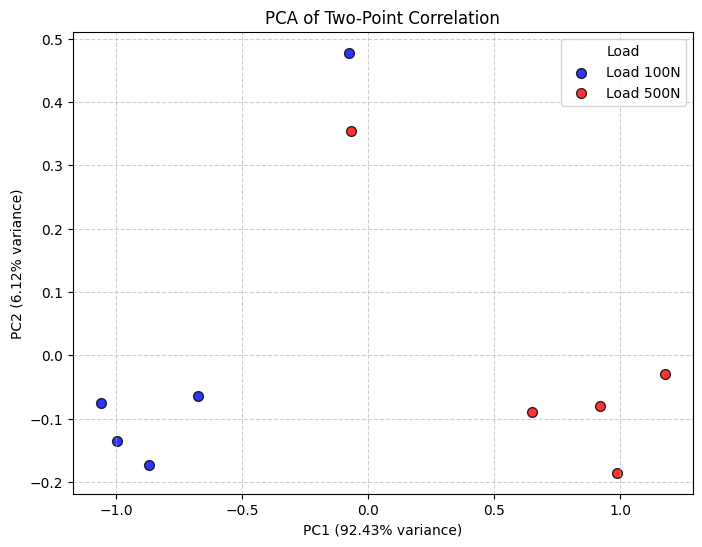

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_results = pca.fit_transform(correlation_profiles)
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance:")
for i, var in enumerate(explained_variance, start=1):
    print(f"PC{i}: {var*100:.2f}%")

colors = {100: 'blue', 500: 'red'}
labels = {100: "Load 100N", 500: "Load 500N"}


fig, ax = plt.subplots(figsize=(8, 6))

for load_value in np.unique(loads):
    mask = (loads == load_value)
    ax.scatter(pca_results[mask, 0], pca_results[mask, 1],
               c=colors[load_value], label=labels[load_value],
               edgecolor='k', s=50, alpha=0.8)

ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xlabel(f"PC1 ({explained_variance[0]*100:.2f}% variance)")
ax.set_ylabel(f"PC2 ({explained_variance[1]*100:.2f}% variance)")
ax.set_title("PCA of Two-Point Correlation")
ax.legend(loc="best", title="Load")
plt.show()


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Reduce to 2 PCA components for classification
pca_2d = PCA(n_components=2).fit_transform(correlation_profiles)

# Train logistic regression
clf = LogisticRegression()
clf.fit(pca_2d, loads)

# Predict
y_pred = clf.predict(pca_2d)
y_proba = clf.predict_proba(pca_2d)[:, 1]  # For AUC

# Metrics
conf_mat = confusion_matrix(loads, y_pred)
f1 = f1_score(loads, y_pred, pos_label=500)
acc = accuracy_score(loads, y_pred)
auc = roc_auc_score(loads, y_proba)
cv_acc = cross_val_score(clf, pca_2d, loads, cv=5).mean()

# Print summary
print("Classification Metrics on PCA (Logistic Regression):\n")
print(f"Accuracy:         {acc:.4f}")
print(f"F1 Score (500N):  {f1:.4f}")
print(f"AUC-ROC:          {auc:.4f}")
print(f"5-Fold CV Acc:    {cv_acc:.4f}")
print("\nConfusion Matrix:")
print(conf_mat)



Classification Metrics on PCA (Logistic Regression):

Accuracy:         0.9000
F1 Score (500N):  0.8889
AUC-ROC:          1.0000
5-Fold CV Acc:    0.9000

Confusion Matrix:
[[5 0]
 [1 4]]
